# Preparation

## Import library

In [25]:
import cubo
import spyndex
import xarray as xr
from dask.distributed import Client
from dask.distributed import LocalCluster
import dask.dataframe as dd
import rioxarray
import geopandas as gpd
import pandas as pd
import planetary_computer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    root_mean_squared_error,
)
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import os
from pathlib import Path
import numpy as np
import rioxarray as rxr
from glob import glob
import datetime
from shapely.geometry import Polygon
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import folium
import gc

In [26]:
def check_and_create_folder(folder_path: Path) -> None:
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

In [27]:
da = pd.read_csv(Path("./data") / "filtered_data.csv")
da["time"] = pd.to_datetime(da["time"])
da = da.set_index("time")
da = da.reset_index()
print(f"Total pixel data filtered with sensor: {len(da)}")
da.head()

Total pixel data filtered with sensor: 19756496


,time,Unnamed: 0,x,y,B02,B03,B04,B08,NDTI,NDWI,SCL,turbidity
0,2023-10-02 23:52:29,0,537750.0,6889860.0,0.1295,0.1243,0.1214,0.1916,NaN,NaN,3.0,NaN
1,2023-10-02 23:52:29,1,537750.0,6889870.0,0.1294,0.1246,0.1202,0.1910,NaN,NaN,3.0,NaN
2,2023-10-02 23:52:29,2,537750.0,6889880.0,0.1298,0.1264,0.1237,0.2082,NaN,NaN,3.0,NaN
3,2023-10-02 23:52:29,3,537750.0,6889890.0,0.1295,0.1284,0.1236,0.2048,NaN,NaN,3.0,NaN
4,2023-10-02 23:52:29,4,537750.0,6889900.0,0.1305,0.1268,0.1228,0.1958,NaN,NaN,3.0,NaN


In [28]:
filtered_data = da[(da["turbidity"].notna() & da["NDTI"].notna())]
print(f"Total pixel data filtered with sensor without Nan: {len(filtered_data)}")
filtered_data.head()

Total pixel data filtered with sensor without Nan: 42


,time,Unnamed: 0,x,y,B02,B03,B04,B08,NDTI,NDWI,SCL,turbidity
84445,2023-10-02 23:52:29,84445,538570.0,6898730.0,0.1278,0.1311,0.1213,0.1224,-0.038827,0.034320,5.0,1.9
91381,2023-10-02 23:52:29,91381,538640.0,6896760.0,0.1298,0.1320,0.1199,0.1240,-0.048035,0.031250,5.0,2.8
301236,2023-10-02 23:52:29,301236,540700.0,6896170.0,0.1220,0.1237,0.1175,0.1132,-0.025705,0.044322,6.0,3.0
1405663,2023-10-12 23:52:29,1405663,541300.0,6895080.0,0.1232,0.1273,0.1146,0.1113,-0.052501,0.067058,5.0,1.9
1472364,2023-10-12 23:52:29,1472364,541950.0,6899740.0,0.1148,0.1189,0.1092,0.1117,-0.042525,0.031223,5.0,1.9


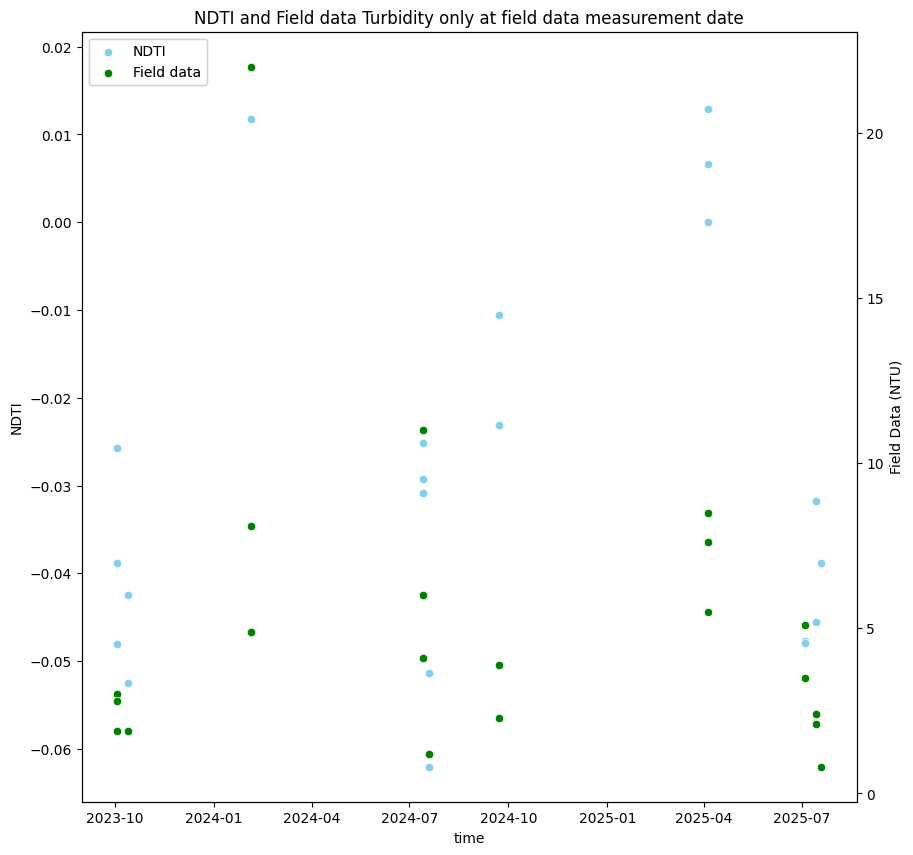

In [64]:
check_and_create_folder(Path("./data") / "plot")
fig, ax1 = plt.subplots(figsize=(10, 10))
ax2 = ax1.twinx()
# sns.lineplot(
#     data=filtered_data,
#     x="time",
#     y="NDTI",
#     errorbar=None,
#     ax=ax1,
#     color="skyblue",
#     label="NDTI",
# )
sns.scatterplot(
    data=filtered_data,
    x="time",
    y="NDTI",
    ax=ax1,
    color="skyblue",
    label="NDTI",
)
ax1.set_ylabel("NDTI")
# ax1.legend(loc=0)
# sns.lineplot(
#     data=filtered_data,
#     x="time",
#     y="turbidity",
#     errorbar=None,
#     ax=ax2,
#     color="green",
#     label="Field data",
# )
sns.scatterplot(
    data=filtered_data,
    x="time",
    y="turbidity",
    ax=ax2,
    color="green",
    label="Field data",
)
ax2.set_ylabel("Field Data (NTU)")
# ax2.legend(loc=0)
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")
plt.title("NDTI and Field data Turbidity only at field data measurement date")
plt.savefig(
    Path("./data")
    / "plot"
    / "NDTI and Field data Turbidity only at field data measurement date.png"
)
plt.show()

In [30]:
print(scipy.stats.pearsonr(filtered_data["NDTI"], filtered_data["turbidity"]))
print(scipy.stats.linregress(filtered_data["NDTI"], filtered_data["turbidity"]))

ln_stat = scipy.stats.linregress(filtered_data["NDTI"], filtered_data["turbidity"])

PearsonRResult(statistic=0.6464535950929766, pvalue=3.751142472701673e-06)
LinregressResult(slope=122.12813173841347, intercept=7.995500864672037, rvalue=0.6464535950929767, pvalue=3.751142472701654e-06, stderr=22.790104832133306, intercept_stderr=0.7972916282283711)


In [31]:
mse = mean_squared_error(filtered_data["turbidity"], filtered_data["NDTI"])
mse

46.44405348506353

In [32]:
mae = mean_absolute_error(filtered_data["turbidity"], filtered_data["NDTI"])
mae

4.989341818380607

In [33]:
rmse = root_mean_squared_error(filtered_data["turbidity"], filtered_data["NDTI"])
rmse

6.814987416354012

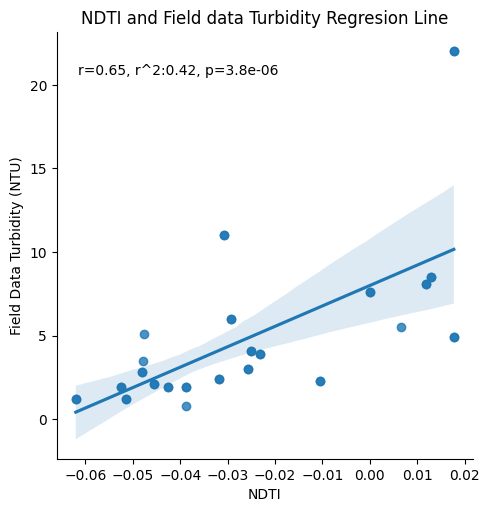

In [68]:
pl = sns.lmplot(x="NDTI", y="turbidity", data=filtered_data, fit_reg=True, height=5)
pl.set_ylabels("Field Data Turbidity (NTU)")


def annotate(data, **kws):
    ax = plt.gca()
    ax.text(
        0.05,
        0.9,
        "r={:.2f}, r^2:{:.2g}, p={:.2g} ".format(
            ln_stat.rvalue,
            ln_stat.rvalue**2,
            ln_stat.pvalue,
        ),
        transform=ax.transAxes,
    )


pl.map_dataframe(annotate)

plt.title("NDTI and Field data Turbidity Regresion Line")
plt.savefig(Path("./data") / "plot" / "NDTI and Field data Regresion Line.png")

plt.show()

In [35]:
# filtered_data_hist = filtered_data.loc[
#     :,
#     (filtered_data.columns != "x") & (filtered_data.columns != "y"),
# ]
# sns.pairplot(filtered_data_hist, hue="turbidity", palette="coolwarm")
# plt.show()

# RF Regresion

In [36]:
filtered_data = filtered_data.sample(frac=1)

In [37]:
X = filtered_data.loc[
    :,
    (filtered_data.columns != "turbidity")
    & (filtered_data.columns != "time")
    & (filtered_data.columns != "x")
    & (filtered_data.columns != "y")
    & (filtered_data.columns != "Unnamed: 0"),
]
X.head()

,B02,B03,B04,B08,NDTI,NDWI,SCL
17865142,0.1198,0.1229,0.1117,0.1069,-0.047741,0.069626,6.0
11706200,0.1114,0.1216,0.1147,0.1085,-0.029200,0.056932,6.0
7690896,0.1135,0.1193,0.1089,0.1087,-0.045574,0.046491,5.0
12808409,0.1131,0.1224,0.1081,0.1103,-0.062039,0.051998,6.0
12875110,0.1112,0.1166,0.1052,0.1169,-0.051398,-0.001285,5.0


In [38]:
y = filtered_data.loc[:, filtered_data.columns == "turbidity"]
y.head()

,turbidity
17865142,5.1
11706200,6.0
7690896,2.1
12808409,1.2
12875110,1.2


In [39]:
random_state = 42

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state
)

In [41]:
rf_regresor = RandomForestRegressor(random_state=random_state)

In [ ]:
rf_regresor.fit(X, y)

In [43]:
y_pred = rf_regresor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
print("MSE: ", mse)
print("MAE: ", mae)
print("R2: ", r2)
print("RMSE: ", rmse)

MSE:  0.34738122222222073
MAE:  0.445222222222221
R2:  0.9616022393558954
RMSE:  0.5893905515209934


In [44]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": np.linspace(0, 0.1, 10),
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_regresor,
    param_grid=param_grid,
    verbose=3,
    cv=5,  # 5 fold cross validation
    scoring="r2",
    n_jobs=-1,
)

In [ ]:
%time
grid_search.fit(X_train, y_train)

In [46]:
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 0.07777777777777778, 'min_samples_split': 2, 'n_estimators': 50}
Best Score: 0.6649300074259211


In [47]:
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test Score:", test_score)

Test Score: 0.8091227866900419
